In [ ]:
from google.colab import drive
drive.mount('/content/drive')     

In [ ]:
!pip install selective-search

In [ ]:
import tensorflow as tf
import os
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import selective_search
from keras.layers import *
from keras.models import Model

In [ ]:
path = '/content/drive/MyDrive/Dataset/Air planes/Images'
annot= '/content/drive/MyDrive/Dataset/Air planes/Airplanes_Annotations'

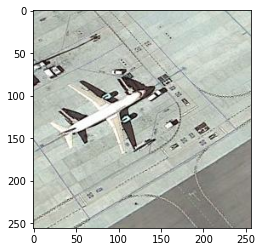

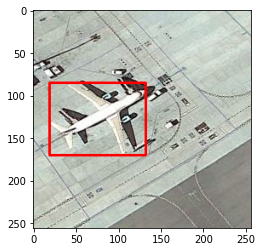

In [ ]:
index = 148
image_path = "airplane_"+str(index)+".jpg"
image = cv.imread(os.path.join(path, image_path))
plt.imshow(image)

annot_path = "airplane_"+str(index)+".csv"
with open(os.path.join(annot, annot_path)) as file:
  csvreader = csv.reader(file, delimiter=" ")
  num = next(csvreader)
  for row in csvreader:
    x1 = int(row[0])
    y1 = int(row[1])
    x2 = int(row[2])
    y2 = int(row[3])
    cv.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
  plt.figure()
  plt.imshow(image)

In [ ]:
im = cv.imread(os.path.join(path,"42850.jpg"))
rects = selective_search.selective_search(im, mode='fast')

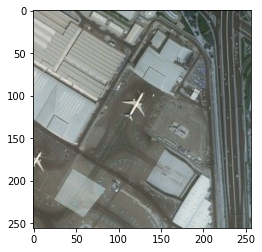

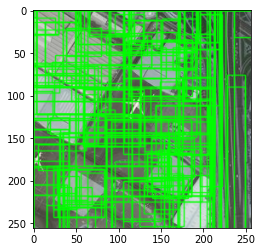

In [ ]:
im_copy = im.copy()
boxes_filter = selective_search.box_filter(rects, min_size=20, topN=200)
for x1, y1, x2, y2 in boxes_filter:
  cv.rectangle(im_copy, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
plt.imshow(im)
plt.figure()
plt.imshow(im_copy)

In [ ]:
def get_iou(bb1, bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bot = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bot < y_top:
    return 0.0
  
  intersection = (x_right - x_left) * (y_bot - y_top)
  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  iou = intersection / float(bb1_area + bb2_area - intersection)

  assert iou >= 0.0 
  assert iou <= 1.0

  return iou

In [ ]:
train_images = []
train_labels = []

for e, i in enumerate(os.listdir(annot)):
  try:
    if i.startswith("airplane"):
      img_name = i.split(".")[0] + ".jpg"
      img = cv.imread(os.path.join(path, img_name))
      img_copy = img.copy()

      gt_values=[]
      
      with open(os.path.join(annot, i)) as file:
        reader = csv.reader(file, delimiter=" ")
        num = next(reader)

        for row in reader:
          x1 = int(row[0])
          y1 = int(row[1])
          x2 = int(row[2])
          y2 = int(row[3])

          gt_values.append({'x1': x1, 'y1':y1, 'x2':x2, 'y2':y2})
      
      regions = selective_search.selective_search(img, mode='fast')

      flag = 0
      counter = 0
      fcounter = 0

      for e, region in enumerate(regions):
        if e < 2000 and flag == 0:
          x1 = int(region[0])
          y1 = int(region[1])
          x2 = int(region[2])
          y2 = int(region[3])
          box = {'x1': x1, 'y1':y1, 'x2':x2, 'y2':y2}

          for gt_value in gt_values:
            iou = get_iou(gt_value, box)

            if counter < 30:
              if iou > 0.7:
                true_image = img_copy[x1:x2, y1:y2]
                resized = cv.resize(true_image, (224, 224), interpolation = cv.INTER_AREA)
                counter += 1
                train_images.append(resized)
                train_labels.append(1)
            
            if fcounter < 30:
              if iou < 0.3:
                false_image = img_copy[x1:x2, y1:y2]
                resized = cv.resize(false_image, (224, 224), interpolation = cv.INTER_AREA)
                fcounter += 1
                train_images.append(resized)
                train_labels.append(0)

          if counter == 30 and fcounter == 30:
            print('enough')
            flag = 1

  except Exception as e:
    print(e)
    print("error in "+img_name)
    continue

In [ ]:
X_new = np.array(train_images)
Y_new = np.array(train_labels)
print(X_new)

[]


In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

ValueError: ignored